#1.Set up environment

In [ ]:
%matplotlib inline

import matplotlib
import scipy.io
from sklearn import preprocessing
import pandas as pd
import scipy.signal
import pickle
import csv

In [ ]:
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)


In [ ]:
import os
import numpy as np, os, sys, joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tarfile

from scipy import optimize
from keras.utils import pad_sequences
import math


from keras import layers, Sequential
from keras.layers import Input, Add, Dense, Activation, ZeroPadding1D, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout,BatchNormalization
from keras.models import Model

import random
import sklearn
import keras.backend as K
from tensorflow.keras import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report



In [ ]:
# Connecting Google Colab to Google Drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/corino/train

Mounted at /gdrive
/gdrive/My Drive/corino/train


#2.Importing segments and their corresponding labels

In [ ]:
save_directory = '/gdrive/MyDrive/corino/Processing_definitivo'
# Change the current working directory
os.chdir(save_directory)

# Load the data from the files
with open('segmenti_totali_check_28_01.txt', 'rb') as data_file:
    segmenti_totali = pickle.load(data_file)
with open('label_check_28_01.txt', 'rb') as data_file:
    label = pickle.load(data_file)

#3.Encoding labels

 Encoding the labels, setting N to 0 and V  to 1 and S to 2, enabling multi class classification

In [ ]:
label_modified = [
    np.where(arr == 'N', 0, arr) for arr in label
]

In [ ]:
label_modified1 = [
    np.where(arr == 'V', 1, arr) for arr in label_modified
]

In [ ]:
label_modified_final = [
    np.where(arr == 'S', 2, arr) for arr in label_modified1
]

# 4.Split between test,train and validation set
The split was done to maintain segmentations related to the same signal of a patient either in the train or in the test set, avoiding having segmentations of a signal in both the train and the test sets.

In [ ]:
prop_train = 0.70  # 70% for train
prop_test = 0.15  # 15% for test
prop_val = 0.15 # 15% for validation


# Perform the split
train_data, temp_data, train_label, temp_label = train_test_split(segmenti_totali, label_modified_final, test_size=1 - prop_train, random_state=seed)
test_data, val_data, test_label, val_label = train_test_split(temp_data, temp_label, test_size=prop_val / (prop_test + prop_val), random_state=seed)


Creation of a dataset by concatenating the various segments from different patients to provide the model with one segment at time, regardless of the patient

In [ ]:
train_seg=[]
for i in range (len(train_data)):
  train_seg.extend(train_data[i])

In [ ]:
test_seg=[]
for i in range (len(test_data)):
  test_seg.extend(test_data[i])

In [ ]:
val_seg=[]
for i in range (len(val_data)):
  val_seg.extend(val_data[i])

In [ ]:
label_train=[]
for i in range (len(train_label)):
  label_train.extend(train_label[i])

In [ ]:
label_test=[]
for i in range (len(test_label)):
  label_test.extend(test_label[i])

In [ ]:
label_validation=[]
for i in range (len(val_label)):
  label_validation.extend(val_label[i])

In [ ]:
train_seg=np.array(train_seg)

In [ ]:
test_seg=np.array(test_seg)

#5.Downsampling

Since the number of class N is much greater than the number of classes V and S, we have decided to apply downsampling of the majority class to achieve more balanced classes


To perform downsampling, we calculated the number of samples for each class and saved the indices of the samples for each class so that we can use them later to create the new training set and label training.

In [ ]:
count_0=0
count_1=0
count_2=0
indici_0=[]
indici_1=[]
indici_2=[]


for i in range(len(label_train)):
  if label_train[i]=='0':
    count_0 += 1
    indici_0.append(i)
  if label_train[i]=='1':
    count_1 += 1
    indici_1.append(i)
  if label_train[i]=='2':
    count_2 += 1
    indici_2.append(i)

In [ ]:
label_train=np.array(label_train)

with downsampling N class is reduced by a factor of five.
This factor was found empirically.

In [ ]:
target_count_class_0 = int(count_0 * (1 / 5)) #select the amount of sample that we want on the class 0
np.random.seed(seed)
downsampled_class_0_indices = np.random.choice(indici_0, size=target_count_class_0, replace=False) #select the index for the majority class

#Combine the indices of the minority and majority classes after downsampling
downsampled_indices = np.concatenate([downsampled_class_0_indices, indici_1,indici_2])

# Create the new downsampled datasets
train_seg = train_seg[downsampled_indices]
label_train = label_train[downsampled_indices]

In [ ]:
downsampled_indices

array([18215, 76421, 87325, ..., 91438, 91439, 91440])

# 6.Class weight

In addition to undersampling, a class weighting technique is used. This choice was made in order to address the problem of unbalanced dataset, because class weight allows to assign different weights to classes during the model training. In particular, samples from the less represented classes are weighted more heavily than those from the more represented classes. This means that errors made on the less represented classes will have a greater impact on the model's loss function during training.



The count has been recalculated since downsampling has been performed.

In [ ]:
count0=0
count1=0
count2=0


for i in range(len(label_train)):
  if label_train[i]=='0':
    count0 += 1
  if label_train[i]=='1':
    count1 += 1
  if label_train[i]=='2':
    count2 += 1

count=count0+count1+count2

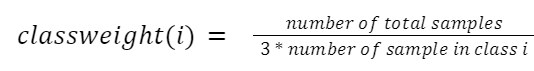

where i represents i-th class
The class weights have been calculated taking into account the frequency of each class as it is reported in this formula

 In addition, when evaluating the performance of the models, it was noticed that class V was the most difficult to classify. Therefore, its weight was multiplied by a factor of 1.1 in order to give it more importance. The factor is chosen empirically.

In [ ]:
weight_for_class_0 = (count / (3 * count0))
weight_for_class_1 = count / (3 * count1)*1.1
weight_for_class_2 = count / (3 * count2)
class_weight = {0: weight_for_class_0, 1:  weight_for_class_1, 2:weight_for_class_2}

In [ ]:
class_weight

{0: 0.4504804787244411, 1: 3.016743799691468, 2: 2.406643757159221}

Perform one-hot encoding of the labels so that we can train the model.

In [ ]:
label_test = tf.keras.utils.to_categorical(label_test, num_classes=3, dtype='int64')

In [ ]:
label_validation = tf.keras.utils.to_categorical(label_validation, num_classes=3, dtype='int64')

In [ ]:
label_train = tf.keras.utils.to_categorical(label_train, num_classes=3, dtype='int64')

# 6.Padding

Since the segments are not of the same length, we applied padding. This is because when training a model, they require data of uniform size to be processed in batches. By adding padding to a sequence, it extends it to a specific length, and we used the length of the longest sequence in the training set for all datasets

In [ ]:
# Calculate the maximum length among all segments in the traning set
lunghezza_massima = max(len(seg) for seg in train_seg)

# Perform padding on all segments.
train_seg_padded = pad_sequences(train_seg, maxlen=lunghezza_massima, padding='post', truncating='post', dtype='float32')
#Now train_seg_padded contains the segments with padding


In [ ]:
lunghezza_massima

223

In [ ]:
# Perform padding on all segments of the validation set
val_seg_padded = pad_sequences(val_seg, maxlen=lunghezza_massima, padding='post', truncating='post', dtype='float32')

In [ ]:
# Perform padding on all segments of the test set
test_seg = pad_sequences(test_seg, maxlen=lunghezza_massima, padding='post', truncating='post', dtype='float32')

prepare the data to be compatible with the model.

In [ ]:
train_seg_padded = np.array(train_seg_padded)
val_seg_padded = np.array(val_seg_padded)
test_seg = np.array(test_seg)

In [ ]:
x = np.expand_dims(train_seg_padded, axis=-1)
val = np.expand_dims(val_seg_padded, axis=-1)
test_seg = np.expand_dims(test_seg, axis=-1)

In [ ]:
y = np.array(label_train, dtype=np.int32)
y_val = np.array(label_validation, dtype=np.int32)
label_test = np.array(label_test, dtype=np.int32)

#7.Classification

# Resnet

ResBs_Conv: This function defines a convolutional-type block. It takes a tensor as input and applies a series of operations, including 1D convolutions, batch normalization, ReLU activation, and dropout. It uses a residual connection to sum the original input to the result of the last convolution.


ResBs_Identity: This function defines an identity-type block.

Resnet: This function creates the overall architecture of the ResNet model. It takes parameters like the number of ResBs blocks (N), the number of channels (ch), the window length (win_len), and the number of output classes. The model starts with a 1D convolutional layer followed by batch normalization and ReLU activation, then goes through a series of ResBs blocks (some convolutional, others identity) and ends with a global pooling layer and an output layer with softmax activation for classifying the output classes.


In [ ]:
# ResNet model definition


def ResBs_Conv(block_input, num_filters):

    # 0. Filter Block input and BatchNormalization
    block_shortcut = Conv1D(num_filters, kernel_size=7, strides=2,  padding='same')(block_input)
    block_shortcut = BatchNormalization()(block_shortcut)

    # 1. First Convolutional Layer
    conv1 = Conv1D(filters=num_filters, kernel_size=7, strides=2, padding='same')(block_input)
    norm1 = BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)
    dropout = Dropout(0.2)(relu1)

    # 2. Second Convolutional Layer
    conv2 = Conv1D(num_filters, kernel_size=7, padding='same')(dropout)
    norm2 = BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = Add()([block_shortcut, norm2])

    # 4. Activation Layer
    relu2 = Activation('relu')(sum)

    return relu2

def ResBs_Identity(block_input, num_filters):

    # 1. First Convolutional Layer
    conv1 = Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)
    dropout = Dropout(0.2)(relu1)

    # 2. Second Convolutional Layer
    conv2 = Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout)
    norm2 = BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = Add()([block_input, norm2])

    # 4. Activation Layer
    relu2 = Activation('relu')(sum)

    return relu2

def resnet(N=8, ch=1, win_len=lunghezza_massima, classes=3):
    ppg_input = Input(shape=(win_len, ch), name='ppg_signal')

    ResNet = Conv1D(filters=64,kernel_size=15, padding = 'same')(ppg_input)
    ResNet = BatchNormalization()(ResNet)
    ResNet = Activation('relu')(ResNet)
    ResNet = MaxPooling1D(pool_size=2, strides = 2)(ResNet)

    # B.5 ResBs (x8) blocks
    # First two ResNet blocks are identity blocks
    ResNet = ResBs_Identity(ResNet, 64)
    ResNet = ResBs_Identity(ResNet, 64)

    filters = 64
    M = int((N - 2)/2)
    for i in range(M):
        filters = filters * 2
        # define N-th ResBs block
        ResNet = ResBs_Conv(ResNet, filters)
        ResNet = ResBs_Identity(ResNet, filters)

    ResNet = GlobalMaxPooling1D(name='gmp_layer')(ResNet)
    ResNet = Flatten()(ResNet)

    # Sigmoid activation function on the last layer
    ResNet = Dense(classes, activation='softmax',  name='final_classifier')(ResNet)

    # Finally the model is composed by connecting inputs to outputs:
    model = Model(inputs=[ppg_input],outputs=ResNet)

    return model

it’s a regularisation technique  that helps prevent overfitting  by monitoring the validation loss. With a patience of 7 epochs, it allows  to interrupt the training process when the model's performance on the validation set stops to improve, thereby enhancing generalisation and avoiding unnecessary training epochs

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", #monitor the validation loss
                                            min_delta=0.001, #improvement
                                            patience=7, #wait 7 epoch -> if there are no improvement stop
                                            verbose=0,
                                            mode="auto", #auto-> loss tends to decrease
                                            baseline=None,
                                            restore_best_weights=True,
                                            )

In [ ]:
resNet_model = resnet(N=8, ch=1, win_len=lunghezza_massima, classes=3)

learning_rate = 0.001
resNet_model.compile(
    optimizer = tfk.optimizers.Adam(),
    loss = tfk.losses.CategoricalCrossentropy(),#We are using categorical cross-entropy since we are in a multi classification task.
    metrics = ['accuracy', 'Precision', 'Recall' ]
)

In [ ]:
resNet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 ppg_signal (InputLayer)     [(None, 223, 1)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 223, 64)              1024      ['ppg_signal[0][0]']          
                                                                                                  
 batch_normalization (Batch  (None, 223, 64)              256       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 223, 64)              0         ['batch_normalization[0][0

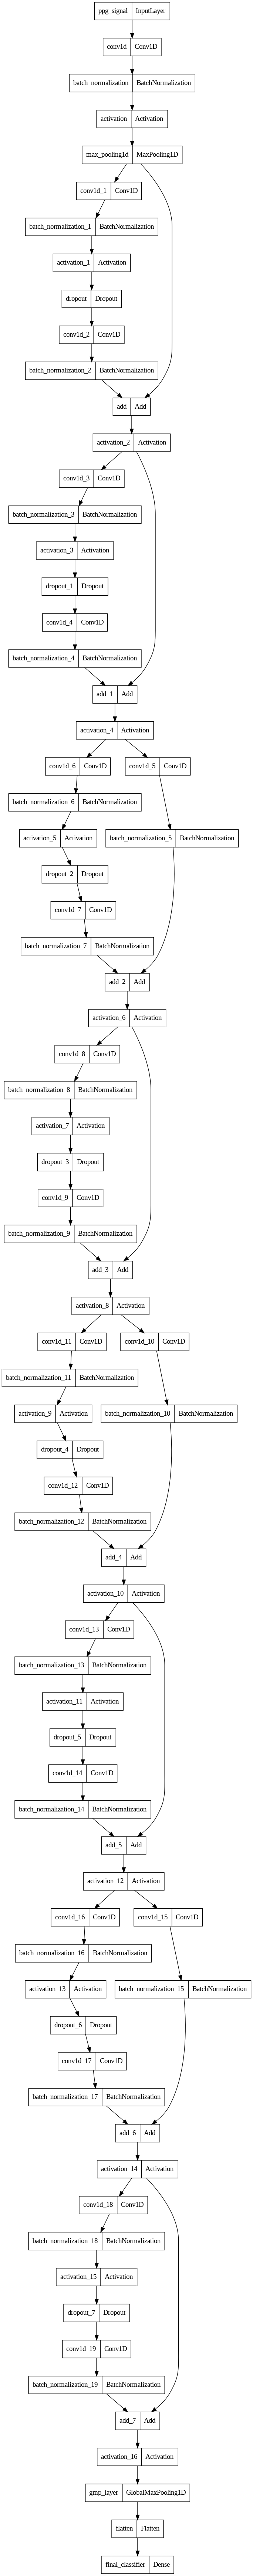

In [ ]:
# model graph

tf.keras.utils.plot_model(
    resNet_model,
    to_file="resNet_model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

In [ ]:
history = resNet_model.fit(
    x = x,
    y = y,
    validation_data=(val, y_val),
    batch_size = 64,
    epochs = 40,
    class_weight = class_weight,
    callbacks=[callback]

).history

Epoch 1/40
362/362 [==============================] - 43s 58ms/step - loss: 0.9349 - accuracy: 0.6834 - precision: 0.7572 - recall: 0.6210 - val_loss: 2.0350 - val_accuracy: 0.0447 - val_precision: 0.0420 - val_recall: 0.0300
Epoch 2/40
362/362 [==============================] - 22s 60ms/step - loss: 0.8228 - accuracy: 0.7096 - precision: 0.7957 - recall: 0.6398 - val_loss: 0.7414 - val_accuracy: 0.6749 - val_precision: 0.7272 - val_recall: 0.5781
Epoch 3/40
362/362 [==============================] - 22s 61ms/step - loss: 0.7676 - accuracy: 0.7298 - precision: 0.8173 - recall: 0.6638 - val_loss: 0.6715 - val_accuracy: 0.7369 - val_precision: 0.8448 - val_recall: 0.6829
Epoch 4/40
362/362 [==============================] - 22s 62ms/step - loss: 0.7502 - accuracy: 0.7369 - precision: 0.8161 - recall: 0.6774 - val_loss: 0.4669 - val_accuracy: 0.8298 - val_precision: 0.8919 - val_recall: 0.7548
Epoch 5/40
362/362 [==============================] - 20s 56ms/step - loss: 0.7295 - accuracy: 0

In [ ]:
y.shape

(23111, 3)

In [ ]:
y_pred_test1 = resNet_model.predict(test_seg)

619/619 [==============================] - 6s 9ms/step


In [ ]:
y_pred_test1.shape

(19790, 3)

In [ ]:

label_test_classes = np.argmax(label_test, axis=1)
y_pred_test_resnet_classes = np.argmax(y_pred_test1, axis=1)

#compute the confusion metrics
conf_matrix_test_resnet = confusion_matrix(label_test_classes,y_pred_test_resnet_classes)

# Compute precision, recall e F1 score
precision_test = precision_score(label_test_classes,y_pred_test_resnet_classes, average='weighted')
recall_test = recall_score(label_test_classes,y_pred_test_resnet_classes, average='weighted')
f1_test = f1_score(label_test_classes, y_pred_test_resnet_classes, average='weighted')

#Print the results
print("Test set - Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}".format(precision_test, recall_test, f1_test))

Test set - Precision: 0.93, Recall: 0.88, F1 Score: 0.90


In [ ]:
conf_matrix_test_resnet

array([[16090,   737,   745],
       [   52,   169,   227],
       [  155,   400,  1215]])

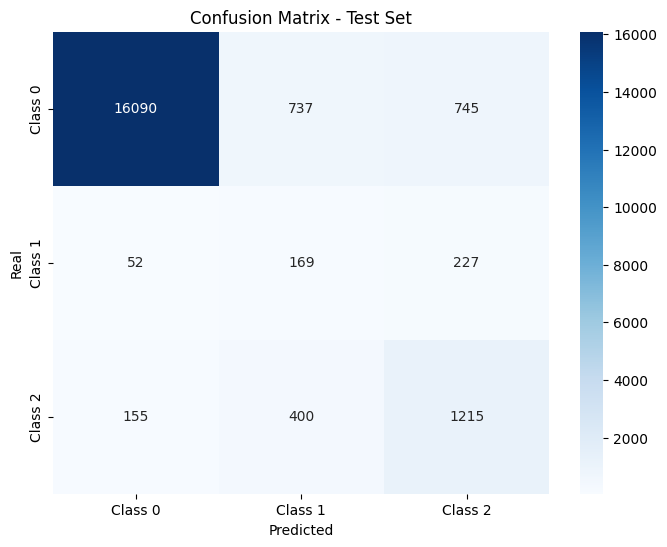

In [ ]:
# Funzione per la visualizzazione della matrice di confusione
def plot_confusion_matrix(conf_matrix, classes, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Real')
    plt.show()

# Plot della matrice di confusione per il set di test
plot_confusion_matrix(conf_matrix_test_resnet, classes=['Class 0', 'Class 1', 'Class 2'], title='Confusion Matrix - Test Set')

Show the individual metrics for the individual classes instead of viewing the overall ones.

In [ ]:
print(classification_report(label_test_classes, y_pred_test_resnet_classes, target_names=['N', 'V', 'S']))

              precision    recall  f1-score   support

           N       0.99      0.92      0.95     17572
           V       0.13      0.38      0.19       448
           S       0.56      0.69      0.61      1770

    accuracy                           0.88     19790
   macro avg       0.56      0.66      0.59     19790
weighted avg       0.93      0.88      0.90     19790



# VGG

In [ ]:
vgg = Sequential()
#First convolutional block
vgg.add(Conv1D(input_shape=(lunghezza_massima,1),filters=64,kernel_size=3,padding="valid", activation="relu"))
vgg.add(Conv1D(filters=64,kernel_size=3,padding="valid", activation="relu"))
vgg.add(MaxPooling1D(pool_size=2,strides=2))
#This block consists of two consecutive 1D convolutional layers with 64 filters each,
#followed by a max-pooling layer with a pool size of 2 and strides of 2.

#Second convolutional block
vgg.add(Conv1D(filters=128, kernel_size=3, padding="valid", activation="relu"))
vgg.add(Conv1D(filters=128, kernel_size=3, padding="valid", activation="relu"))
vgg.add(MaxPooling1D(pool_size=2,strides=2))
#Similar to the first block, this block has two convolutional layers with 128 filters each, followed by max-pooling.

#Third convolutional block
vgg.add(Conv1D(filters=256, kernel_size=3, padding="valid", activation="relu"))
vgg.add(Conv1D(filters=256, kernel_size=3, padding="valid", activation="relu"))
vgg.add(Conv1D(filters=256, kernel_size=3, padding="valid", activation="relu"))
vgg.add(MaxPooling1D(pool_size=2,strides=2))
#This block contains three convolutional layers with 256 filters each, followed by max-pooling.

vgg.add(tfk.layers.GlobalMaxPooling1D())
vgg.add (Dense(512, activation='relu'))
vgg.add (Dropout(0.4))
vgg.add (Dense(3,activation='softmax')) #softmax output function due to we have multi class classification


In [ ]:
vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 221, 64)           256       
                                                                 
 conv1d_21 (Conv1D)          (None, 219, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 109, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_22 (Conv1D)          (None, 107, 128)          24704     
                                                                 
 conv1d_23 (Conv1D)          (None, 105, 128)          49280     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 52, 128)           0         
 g1D)                                                   

In [ ]:
learning_rate = 0.001

vgg.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss= 'categorical_crossentropy',
    metrics=[
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),
    ]
)

In [ ]:
history = vgg.fit(
    x = x,
    y = y,
    validation_data=(val, y_val),
    batch_size = 64,
    epochs = 40,
    class_weight = class_weight,
    callbacks=[callback]

).history

Epoch 1/40
362/362 [==============================] - 10s 16ms/step - loss: 0.8667 - precision: 0.8855 - recall: 0.5599 - val_loss: 0.6535 - val_precision: 0.9458 - val_recall: 0.6672
Epoch 2/40
362/362 [==============================] - 5s 13ms/step - loss: 0.8271 - precision: 0.8769 - recall: 0.5976 - val_loss: 0.5777 - val_precision: 0.9076 - val_recall: 0.6879
Epoch 3/40
362/362 [==============================] - 5s 14ms/step - loss: 0.8078 - precision: 0.8407 - recall: 0.6277 - val_loss: 0.6886 - val_precision: 0.8595 - val_recall: 0.6037
Epoch 4/40
362/362 [==============================] - 5s 13ms/step - loss: 0.7863 - precision: 0.8434 - recall: 0.6339 - val_loss: 0.5995 - val_precision: 0.8069 - val_recall: 0.6297
Epoch 5/40
362/362 [==============================] - 6s 17ms/step - loss: 0.7780 - precision: 0.8375 - recall: 0.6416 - val_loss: 0.5102 - val_precision: 0.9147 - val_recall: 0.6876
Epoch 6/40
362/362 [==============================] - 5s 13ms/step - loss: 0.7600 - 

In [ ]:
y_pred_test2 = vgg.predict(test_seg)

619/619 [==============================] - 2s 3ms/step


In [ ]:
label_test_classes = np.argmax(label_test, axis=1)
y_pred_test_classes_vgg = np.argmax(y_pred_test2, axis=1)

conf_matrix_test_vgg = confusion_matrix(label_test_classes,y_pred_test_classes_vgg)

precision_test = precision_score(label_test_classes, y_pred_test_classes_vgg, average='weighted')
recall_test = recall_score(label_test_classes, y_pred_test_classes_vgg, average='weighted')
f1_test = f1_score(label_test_classes,y_pred_test_classes_vgg, average='weighted')

print("Test set - Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}".format(precision_test, recall_test, f1_test))


Test set - Precision: 0.92, Recall: 0.88, F1 Score: 0.90


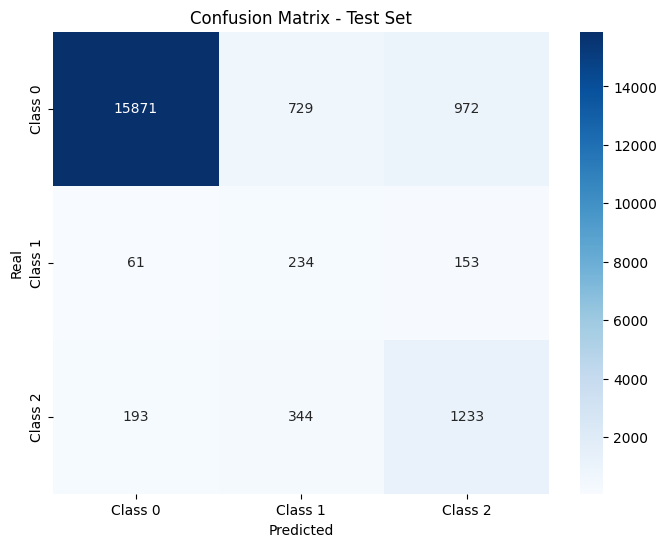

In [ ]:

def plot_confusion_matrix(conf_matrix, classes, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Real')
    plt.show()

plot_confusion_matrix(conf_matrix_test_vgg, classes=['Class 0', 'Class 1', 'Class 2'], title='Confusion Matrix - Test Set')

In [ ]:
print(classification_report(label_test_classes, y_pred_test_classes_vgg, target_names=['N', 'V', 'S']))

              precision    recall  f1-score   support

           N       0.98      0.90      0.94     17572
           V       0.18      0.52      0.27       448
           S       0.52      0.70      0.60      1770

    accuracy                           0.88     19790
   macro avg       0.56      0.71      0.60     19790
weighted avg       0.92      0.88      0.90     19790



#8.Combination of the prediction

A decision has been made to combine previously trained models through average of their predictions to enhance the overall robustness of our predictions.  So if If a particular model exhibits significantly lower performance in certain instances, the averaging process helps mitigate these anomalies, providing a more fair assessment of the overall forecasting capabilities

It was noticed that the VGG performed better; therefore, when combining the predictions, greater weight was assigned to the VGG predictions.

In [ ]:
out = (y_pred_test1 + 3*y_pred_test2) / 2

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

label_test_classes = np.argmax(label_test, axis=1)
y_pred_test_classes_comb = np.argmax(out, axis=1)

conf_matrix_test_comb = confusion_matrix(label_test_classes,y_pred_test_classes_comb )

precision_test = precision_score(label_test_classes,y_pred_test_classes_comb , average='weighted')
recall_test = recall_score(label_test_classes, y_pred_test_classes_comb , average='weighted')
f1_test = f1_score(label_test_classes,y_pred_test_classes_comb , average='weighted')

print("Test set - Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}".format(precision_test, recall_test, f1_test))

Test set - Precision: 0.93, Recall: 0.88, F1 Score: 0.90


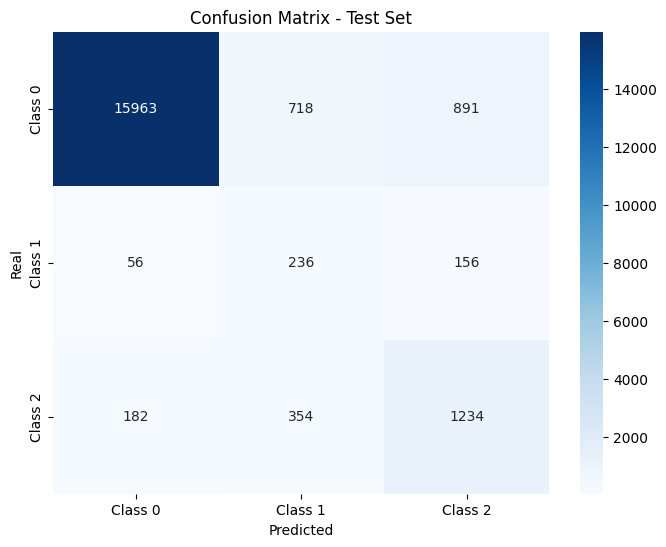

In [ ]:

def plot_confusion_matrix(conf_matrix, classes, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Real')
    plt.show()

plot_confusion_matrix(conf_matrix_test_comb, classes=['Class 0', 'Class 1', 'Class 2'], title='Confusion Matrix - Test Set')

In [ ]:
print(classification_report(label_test_classes, y_pred_test_classes_comb, target_names=['N', 'V', 'S']))

              precision    recall  f1-score   support

           N       0.99      0.91      0.95     17572
           V       0.18      0.53      0.27       448
           S       0.54      0.70      0.61      1770

    accuracy                           0.88     19790
   macro avg       0.57      0.71      0.61     19790
weighted avg       0.93      0.88      0.90     19790



For this type of classification, we have adopted the Cohen's Kappa as our meaningful metric. This metric allows us to assess how closely our model aligns with the provided data, particularly in predicting them. It provides an estimate of our model's ability to predict data compared to a model that predicts data randomly following the data distribution.
Both global model metrics and performance metrics for each class are analyzed in this task, with a thorough examination and study of the confusion matrix to understand where the model achieved optimal performance and where the most significant errors are made on the test set.


In [ ]:
from sklearn.metrics import balanced_accuracy_score
bal_acc=balanced_accuracy_score(label_test_classes,y_pred_test_classes_comb)

In [ ]:
bal_acc

0.7107982425326177

In [ ]:
from sklearn.metrics import cohen_kappa_score

In [ ]:
kappa = cohen_kappa_score(label_test_classes,y_pred_test_classes_comb)

In [ ]:
kappa

0.5442006995452093

#9.Confidence on  Softmax ResNet as our own metric

In [ ]:
# Ora puoi accedere ai valori della softmax per ogni classe
probabilities_class_0 = y_pred_test1[:, 0]
probabilities_class_1 = y_pred_test1[:, 1]
probabilities_class_2 = y_pred_test1[:, 2]

print("Probabilità classe 0:", probabilities_class_0)
print("Probabilità classe 1:", probabilities_class_1)
print("Probabilità classe 2:", probabilities_class_2)

Probabilità classe 0: [0.94898844 0.9854021  0.9749707  ... 0.22028263 0.579158   0.91177636]
Probabilità classe 1: [0.01798628 0.00426308 0.01022742 ... 0.44927242 0.21754317 0.03313721]
Probabilità classe 2: [0.03302527 0.01033484 0.01480188 ... 0.33044496 0.2032989  0.05508646]


## Confidenza Softmax classe 0 corretti


In [ ]:
diff_giusti_0=[]
diff_giusti_1=[]
diff_giusti_2=[]
count_0=0
count_1=0
count_2=0
for i in range(len(y_pred_test1)):
  classe=0
  if probabilities_class_0[i]>probabilities_class_1[i] and probabilities_class_0[i]>probabilities_class_2[i]:
    classe = 0
  if probabilities_class_1[i]>probabilities_class_0[i] and probabilities_class_1[i]>probabilities_class_2[i]:
    classe = 1
  if probabilities_class_2[i]>probabilities_class_0[i] and probabilities_class_2[i]>probabilities_class_1[i]:
    classe = 2
  if label_test_classes[i]==classe:
    if classe ==0:
      count_0+=1
      if probabilities_class_1[i]>probabilities_class_2[i]:
        diff_giusti_0.append(abs(probabilities_class_0[i]-probabilities_class_1[i]))
      if probabilities_class_2[i]>probabilities_class_1[i]:
        diff_giusti_0.append(abs(probabilities_class_0[i]-probabilities_class_2[i]))
    if classe ==1:
      count_1+=1
      if probabilities_class_0[i]>probabilities_class_2[i]:
        diff_giusti_1.append(abs(probabilities_class_1[i]-probabilities_class_0[i]))
      if probabilities_class_2[i]>probabilities_class_0[i]:
        diff_giusti_1.append(abs(probabilities_class_1[i]-probabilities_class_2[i]))
    if classe ==2:
      count_2+=1
      if probabilities_class_0[i]>probabilities_class_1[i]:
        diff_giusti_2.append(abs(probabilities_class_2[i]-probabilities_class_0[i]))
      if probabilities_class_1[i]>probabilities_class_0[i]:
        diff_giusti_2.append(abs(probabilities_class_2[i]-probabilities_class_1[i]))

In [ ]:
diff_giusti_tot_0=0
for i in range(len(diff_giusti_0)):
  diff_giusti_tot_0+=diff_giusti_0[i]

In [ ]:
confidenza_softmax_0 = diff_giusti_tot_0/count_0

In [ ]:
confidenza_softmax_0

0.8555508033896881

## Confidenza Softmax classe 1 corretti

In [ ]:
diff_giusti_tot_1=0
for i in range(len(diff_giusti_1)):
  diff_giusti_tot_1+=diff_giusti_1[i]

In [ ]:
confidenza_softmax_1 = diff_giusti_tot_1/count_1

In [ ]:
confidenza_softmax_1

0.18626763649059064

## Confidenza Softmax classe 2 corretti

In [ ]:
diff_giusti_tot_2=0
for i in range(len(diff_giusti_2)):
  diff_giusti_tot_2+=diff_giusti_2[i]

In [ ]:
confidenza_softmax_2 = diff_giusti_tot_2/count_2

In [ ]:
confidenza_softmax_2

0.3310054904536197

#10.Confidence on Softmax VGG as our own metric

In [ ]:
# Ora puoi accedere ai valori della softmax per ogni classe
probabilities_class_0 =  y_pred_test2[:, 0]
probabilities_class_1 =  y_pred_test2[:, 1]
probabilities_class_2 =  y_pred_test2[:, 2]

print("Probabilità classe 0:", probabilities_class_0)
print("Probabilità classe 1:", probabilities_class_1)
print("Probabilità classe 2:", probabilities_class_2)

Probabilità classe 0: [0.9854255 0.9915388 0.983236  ... 0.5969064 0.6538295 0.9430412]
Probabilità classe 1: [0.01051615 0.00467506 0.01031866 ... 0.29332042 0.2620423  0.0262251 ]
Probabilità classe 2: [0.00405825 0.00378604 0.00644534 ... 0.10977312 0.08412817 0.03073375]


## Confidenza Softmax classe 0 corretti


In [ ]:
diff_giusti_0=[]
diff_giusti_1=[]
diff_giusti_2=[]
count_0=0
count_1=0
count_2=0
for i in range(len(y_pred_test1)):
  classe=0
  if probabilities_class_0[i]>probabilities_class_1[i] and probabilities_class_0[i]>probabilities_class_2[i]:
    classe = 0
  if probabilities_class_1[i]>probabilities_class_0[i] and probabilities_class_1[i]>probabilities_class_2[i]:
    classe = 1
  if probabilities_class_2[i]>probabilities_class_0[i] and probabilities_class_2[i]>probabilities_class_1[i]:
    classe = 2
  if label_test_classes[i]==classe:
    if classe ==0:
      count_0+=1
      if probabilities_class_1[i]>probabilities_class_2[i]:
        diff_giusti_0.append(abs(probabilities_class_0[i]-probabilities_class_1[i]))
      if probabilities_class_2[i]>probabilities_class_1[i]:
        diff_giusti_0.append(abs(probabilities_class_0[i]-probabilities_class_2[i]))
    if classe ==1:
      count_1+=1
      if probabilities_class_0[i]>probabilities_class_2[i]:
        diff_giusti_1.append(abs(probabilities_class_1[i]-probabilities_class_0[i]))
      if probabilities_class_2[i]>probabilities_class_0[i]:
        diff_giusti_1.append(abs(probabilities_class_1[i]-probabilities_class_2[i]))
    if classe ==2:
      count_2+=1
      if probabilities_class_0[i]>probabilities_class_1[i]:
        diff_giusti_2.append(abs(probabilities_class_2[i]-probabilities_class_0[i]))
      if probabilities_class_1[i]>probabilities_class_0[i]:
        diff_giusti_2.append(abs(probabilities_class_2[i]-probabilities_class_1[i]))

In [ ]:
diff_giusti_tot_0=0
for i in range(len(diff_giusti_0)):
  diff_giusti_tot_0+=diff_giusti_0[i]

In [ ]:
confidenza_softmax_0 = diff_giusti_tot_0/count_0

In [ ]:
confidenza_softmax_0

0.8810741621208822

## Confidenza Softmax classe 1 corretti

In [ ]:
diff_giusti_tot_1=0
for i in range(len(diff_giusti_1)):
  diff_giusti_tot_1+=diff_giusti_1[i]

In [ ]:
confidenza_softmax_1 = diff_giusti_tot_1/count_1

In [ ]:
confidenza_softmax_1

0.1930267122776612

## Confidenza Softmax classe 2 corretti

In [ ]:
diff_giusti_tot_2=0
for i in range(len(diff_giusti_2)):
  diff_giusti_tot_2+=diff_giusti_2[i]

In [ ]:
confidenza_softmax_2 = diff_giusti_tot_2/count_2

In [ ]:
confidenza_softmax_2

0.1604960966322202